In [5]:
import random

import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import tensorflow as tf
from tensorflow import keras as k
import sounddevice as sd
import uuid
import json
import math
from time import sleep
from PIL import Image


In [11]:
def record(record_number = 10, count = 0, fs = 44100, duration = 2, meta_data_file = 'data/sound/meta.txt', label = 'one',mode='w'):

    meta_data = {}

    f = open(meta_data_file, mode=mode)

    #collect n number of samples
    for i in range (record_number):
        print ("Recording in 1...")
        sleep(1)
        print ("Recording...")
        f_name = str(count)

        meta_data['id'] = uuid.uuid4().hex
        meta_data['sampling_rate'] = fs
        meta_data['duration'] = duration
        meta_data['file_name'] = str(count) + '.npy'
        meta_data['label'] = label

        #sample data from mic
        val = sd.rec(frames=fs*duration, samplerate=fs, channels=1)
        sd.wait()

        # transform obj to string
        meta_json_data = json.dumps(meta_data)
        f.write(meta_json_data + '\n')


        np.save('data/sound/'+f_name+'.npy',val)

        count += 1
        print ("Recording...Done")
        print('meta info:', meta_data)

    f.close()
    print ("Recording...Done")

In [13]:
record(record_number=100,label='right')

Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'eca6fd87f8af4622a19bfc743f2495e3', 'sampling_rate': 44100, 'duration': 2, 'file_name': '0.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '53b5af8db77b4e02b95e1dfbf745744b', 'sampling_rate': 44100, 'duration': 2, 'file_name': '1.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'fc4975d66d434540aaf2d0881c9cdc68', 'sampling_rate': 44100, 'duration': 2, 'file_name': '2.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'af06ce1df9ef4507b6946d35825eeb52', 'sampling_rate': 44100, 'duration': 2, 'file_name': '3.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '2d8c8c7491104c73a3554ca2d8077131', 'sampling_rate': 44100, 'duration': 2, 'file_name': '4.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '6790d33af0b0441b914f9a81c184

In [14]:
record(record_number=100,count=100,mode='a',label='left')

Recording in 1...
Recording...
Recording...Done
meta info: {'id': '38e839231016409196e05101a27250b2', 'sampling_rate': 44100, 'duration': 2, 'file_name': '100.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '156b152a8f964032ac3808738bf640b1', 'sampling_rate': 44100, 'duration': 2, 'file_name': '101.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '0804fca96b98490db253a49467b15de9', 'sampling_rate': 44100, 'duration': 2, 'file_name': '102.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '6df740e0aadf43e489426e52945c8fd7', 'sampling_rate': 44100, 'duration': 2, 'file_name': '103.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'dc44c8f1d633423096c886ce6703edfd', 'sampling_rate': 44100, 'duration': 2, 'file_name': '104.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '61404116dca94d23913b4cb

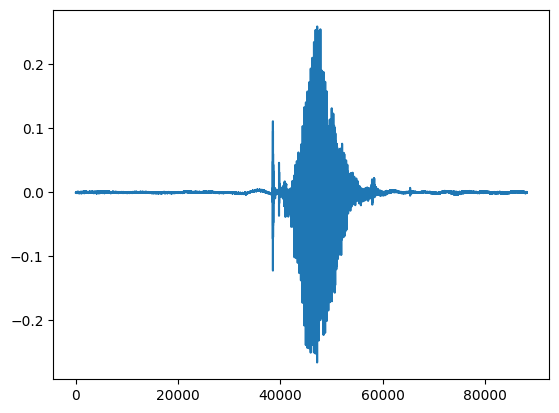

In [20]:
val = np.load('data/sound/40.npy')
plt.plot(val)

In [2]:
def augment_dataset(dataset, meta_data_file):

    meta_data = {}

    scaling_factor = 1.5
    noise_std = 0.1

    count = len(dataset)
    f = open(meta_data_file, mode='a')
    for data in dataset:
        # augment data

        sample = np.load('data/sound/'+data['file_name'])
        # # meta data
        # meta_data['id'] = uuid.uuid4().hex
        # meta_data['sampling_rate'] = data['sampling_rate']
        # meta_data['duration'] = data['duration']
        # meta_data['file_name'] = str(count) + '.npy'
        # meta_data['label'] = data['label']
        #
        #  # transform obj to string
        # meta_json_data = json.dumps(meta_data)
        # f.write(meta_json_data + '\n')
        #
        #
        # # # add white noise
        # # wn = np.random.randn(len(sample))
        # # temp1 = sample[:len(sample)//10] + 0.005*wn
        # # temp2 = sample[len(sample)//10:len(sample)//5] + 0.005*wn
        # # temp3 = sample[len(sample)//5:3*len(sample)//5] + 0.005*wn
        # # temp4 = sample[3*len(sample)//5:] + 0.005*wn
        # # sample_augmented = np.concatenate((temp1,temp2,temp3,temp4),axis=0)
        # # np.save('data/sound/'+str(count)+'.npy',sample_augmented)
        # # count += 1

        #-----------------------------------------------------------------

        # meta data
        meta_data['id'] = uuid.uuid4().hex
        meta_data['sampling_rate'] = data['sampling_rate']
        meta_data['duration'] = data['duration']
        meta_data['file_name'] = str(count) + '.npy'
        meta_data['label'] = data['label']

        # transform obj to string
        meta_json_data = json.dumps(meta_data)
        f.write(meta_json_data + '\n')

        # time shifting
        sample_augmented = np.roll(sample, len(sample)//10)
        np.save('data/sound/'+str(count)+'.npy',sample_augmented)
        count += 1

        #-----------------------------------------------------------------

        # meta data
        meta_data['id'] = uuid.uuid4().hex
        meta_data['sampling_rate'] = data['sampling_rate']
        meta_data['duration'] = data['duration']
        meta_data['file_name'] = str(count) + '.npy'
        meta_data['label'] = data['label']

         # transform obj to string
        meta_json_data = json.dumps(meta_data)
        f.write(meta_json_data + '\n')

        # stretching
        sample_augmented = sample*scaling_factor
        np.save('data/sound/'+str(count)+'.npy',sample_augmented)
        count += 1

        # #-----------------------------------------------------------------
        #
        # # meta data
        # meta_data['id'] = uuid.uuid4().hex
        # meta_data['sampling_rate'] = data['sampling_rate']
        # meta_data['duration'] = data['duration']
        # meta_data['file_name'] = str(count) + '.npy'
        # meta_data['label'] = data['label']
        #
        # # transform obj to string
        # meta_json_data = json.dumps(meta_data)
        # f.write(meta_json_data + '\n')
        #
        # # pitch shifting
        # np.save('data/sound/'+str(count)+'.npy',sample_augmented)
        # count += 1


    f.close()

In [3]:
def data_loader(file_name):
    f = open(file_name,'r')

    data = []
    lines = f.readlines()

    for l in lines:
        obj_data = json.loads(l)
        data.append(obj_data)

    f.close()
    return data

In [8]:
data = data_loader('data/sound/meta.txt')
augment_data = augment_dataset(data,meta_data_file='data/sound/meta.txt')


In [12]:
data = data_loader('data/sound/meta.txt')


In [20]:
def remove_noise(input_file,output_file, noise_level):
    # Load the sound file
    sound = np.load(input_file)

    # Calculate the threshold based on the noise level
    threshold = np.max(sound) * noise_level

    # Remove the noise by setting values below the threshold to 0
    sound[np.abs(sound) < threshold] = 0

    # Save the denoised sound to a new npy file
    np.save(output_file, sound)


In [41]:
for d in data:
    remove_noise('data/sound/'+d['file_name'],'data/sound_clean/'+d['file_name'],0.013)

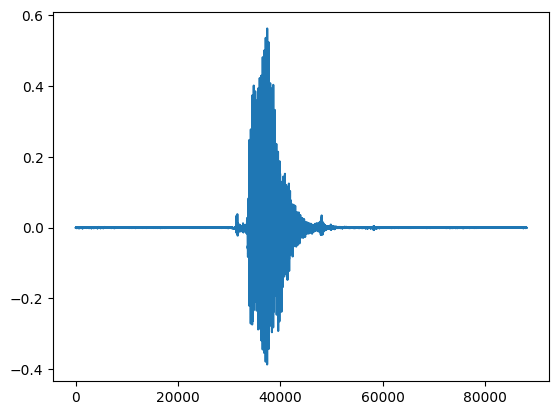

In [45]:
val = np.load('data/sound/1.npy')
plt.plot(val)

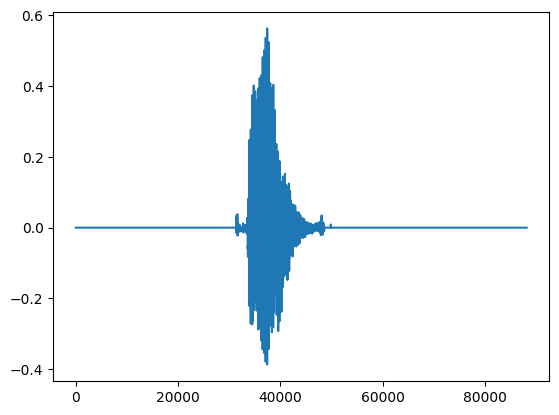

In [43]:
val1 = np.load('data/sound_clean/1.npy')
plt.plot(val1)